# Read wind data

In [ ]:
require(oce, warn.conflicts = FALSE)

In [2]:
library(tidyverse, warn.conflicts = FALSE)

In [4]:
library(cowplot, warn.conflicts = FALSE)
library(scales, warn.conflicts = FALSE)

# library to read matlab data formats into R
library(reshape2)
library(lubridate)

# set strings as factors to false
options(stringsAsFactors = FALSE)

In [5]:
wind_ds <- read.csv("ERA5_reanalyisis_monthly.csv")

wind_ds$time = parse_date_time(wind_ds$time, orders = "%Y-%m-%d H:M:S")

### add new Date column (month resolution)

In [6]:
wind_ds_monthly <- wind_ds %>%
  mutate(time_month = format(time, format = "%m-%Y"))

In [238]:
str(wind_ds)

'data.frame':	998 obs. of  261 variables:
 $ time      : POSIXct, format: "1978-12-31 18:00:00" "1979-01-01 00:00:00" ...
 $ u100      : num  NA -6.81 NA -9.42 NA ...
 $ v100      : num  NA -3.93 NA -4.43 NA ...
 $ u10n      : num  NA -5.64 NA -7.58 NA ...
 $ u10       : num  NA -5.56 NA -7.51 NA ...
 $ v10n      : num  NA -3.44 NA -3.75 NA ...
 $ v10       : num  NA -3.38 NA -3.72 NA ...
 $ si10      : num  NA 6.88 NA 8.66 NA ...
 $ d2m       : num  NA 295 NA 295 NA ...
 $ t2m       : num  NA 297 NA 298 NA ...
 $ p140209   : num  NA 1.16 NA 1.16 NA ...
 $ anor      : num  NA 0.785 NA 0.785 NA ...
 $ isor      : num  NA 0 NA 0 NA 0 NA 0 NA 0 ...
 $ bfi       : num  NA 0.0758 NA 0.1308 NA ...
 $ bld       : num  136360 NA 202031 NA 131401 ...
 $ blh       : num  NA 518 NA 588 NA ...
 $ chnk      : num  NA 0.0135 NA 0.0178 NA ...
 $ cdir      : num  18786336 NA 20692176 NA 22012240 ...
 $ cbh       : num  1872 NA 3074 NA 3181 ...
 $ cdww      : num  NA 0.000966 NA 0.001087 NA ...
 $ cape

# read NISKIN data (from csv)

other datasets:
- PINTDF_integratedChlorophyll.csv
- MLD2EuZ_2.csv
- biogeochembact_dtypes.csv
- niskin_dtypes.csv


In [8]:
niskin_ds <- read.csv("../VeryNEWESTCariacoData/niskin_dtypes.csv")

#niskin_ds$time = parse_date_time(niskin_ds$time, orders = "%Y-%m-%d H:M:S")

In [239]:
str(niskin_ds)

'data.frame':	4394 obs. of  98 variables:
 $ unlimited                  : int  0 1 2 3 4 5 6 7 8 9 ...
 $ Cruise_number              : int  1 1 1 1 1 1 1 1 1 1 ...
 $ Cruise_ID_1                : chr  "93HG_001" "93HG_001" "93HG_001" "93HG_001" ...
 $ Cruise_ID_2                : chr  "CAR-001" "CAR-001" "CAR-001" "CAR-001" ...
 $ Leg                        : int  2 2 2 2 2 2 2 2 2 2 ...
 $ Day                        : int  8 8 8 8 8 8 8 8 8 8 ...
 $ Month                      : int  11 11 11 11 11 11 11 11 11 11 ...
 $ Year                       : int  1995 1995 1995 1995 1995 1995 1995 1995 1995 1995 ...
 $ Latitude                   : num  10.5 10.5 10.5 10.5 10.5 10.5 10.5 10.5 10.5 10.5 ...
 $ Longitude                  : num  -64.7 -64.7 -64.7 -64.7 -64.7 ...
 $ Hydro_cast_no              : num  1 1 1 1 1 1 1 1 3 3 ...
 $ Depth_target               : num  1 7 15 25 35 55 75 100 150 200 ...
 $ Depth_real                 : num  1.5 6.5 15 25 35 ...
 $ O2_ml_L                    : n

# interpolate niskin_ds

In [48]:
niskin_ds$DATE <- paste(niskin_ds$Year,'-',niskin_ds$Month,'-',niskin_ds$Day, sep='')

In [55]:
# Function to read specific verfication type from dataset

prepdataframe <- function(variable='', datasource='niskin'){
    if(datasource=='niskin'){
    DF <- niskin_ds
    DF$date <- as.Date(DF$DATE, format="%Y-%m-%d")
    DF$depth <- DF$Depth_real
    #print(names(DF))
        
    VarDF <- DF %>%
      select(date, variable, depth) %>%
      gather(key='key',value = "value", -date, -depth)
    #head(VarDF)
    }
    
    return(VarDF)
}

In [109]:
# Interpolate
interpolateDF <- function(DF,func='oce-rr'){
    zz <- seq(0, 200, 1)
    
    if(func=='linear'){
        IntDF <- DF %>%
            group_by(date) %>%
            filter(sum(!is.na(value))>1) %>%
            do(data.frame(value_int = with(.,approx(depth, value, zz)), depth = zz)) 
        
        IntDF <- IntDF %>% 
              rename(
                value_int = value_int.y
                )
        IntDF$value_int.x <- NULL
        }
    
    else if(func=='oce-rr'){
        IntDF <- DF %>%
            group_by(date) %>%
            do(data.frame(value_int = with(.,oceApprox(depth, value, zz, "rr")), depth = zz)) 
        }
    
    return(IntDF)
}

In [143]:
wind_ds_monthly

In [222]:
interpolatedmerge <- function(var, windvar){
 
    niskin_dat <- prepdataframe(var)

    niskin_int <- interpolateDF(niskin_dat, 'linear')   
    
    niskin_sum <- niskin_int %>%
        group_by(date) %>%
        filter(depth<101) %>%
        filter(sum(is.na(value_int))<20) %>%
        summarize(value_sum = sum(value_int, na.rm=TRUE), 
                  value_mean = mean(value_int, na.rm=TRUE),
                  value_intgrtd = value_mean * 100,
                  NAs = sum(is.na(value_int)), .groups="keep")
    
    niskin_sum_monthly <- niskin_sum %>%
          mutate(time_month = format(date, format="%m-%Y"))
    
    wind_ds_var <- wind_ds_monthly %>%
          select(time_month, windvar)
    
    wind_niskin <- merge(wind_ds_var, niskin_sum_monthly, all=TRUE)
    
    wind_niskin$time <- parse_date_time(wind_niskin$time_month, orders="%m-%Y")
    
    wind_niskin_addyear <- wind_niskin %>%
        mutate(year = format(date, format="%Y")) %>%
        group_by(year) %>%
        mutate(value_yearly_mean = mean(value_intgrtd, na.rm=TRUE))

    
    return(wind_niskin_addyear)
}

In [223]:
# str(niskin_ds)

In [247]:
options(repr.plot.width=15, repr.plot.height=7)

`geom_smooth()` using formula 'y ~ x'

Warning message:
“Removed 500 rows containing non-finite values (stat_smooth).”
Warning message:
“Removed 500 rows containing missing values (geom_point).”


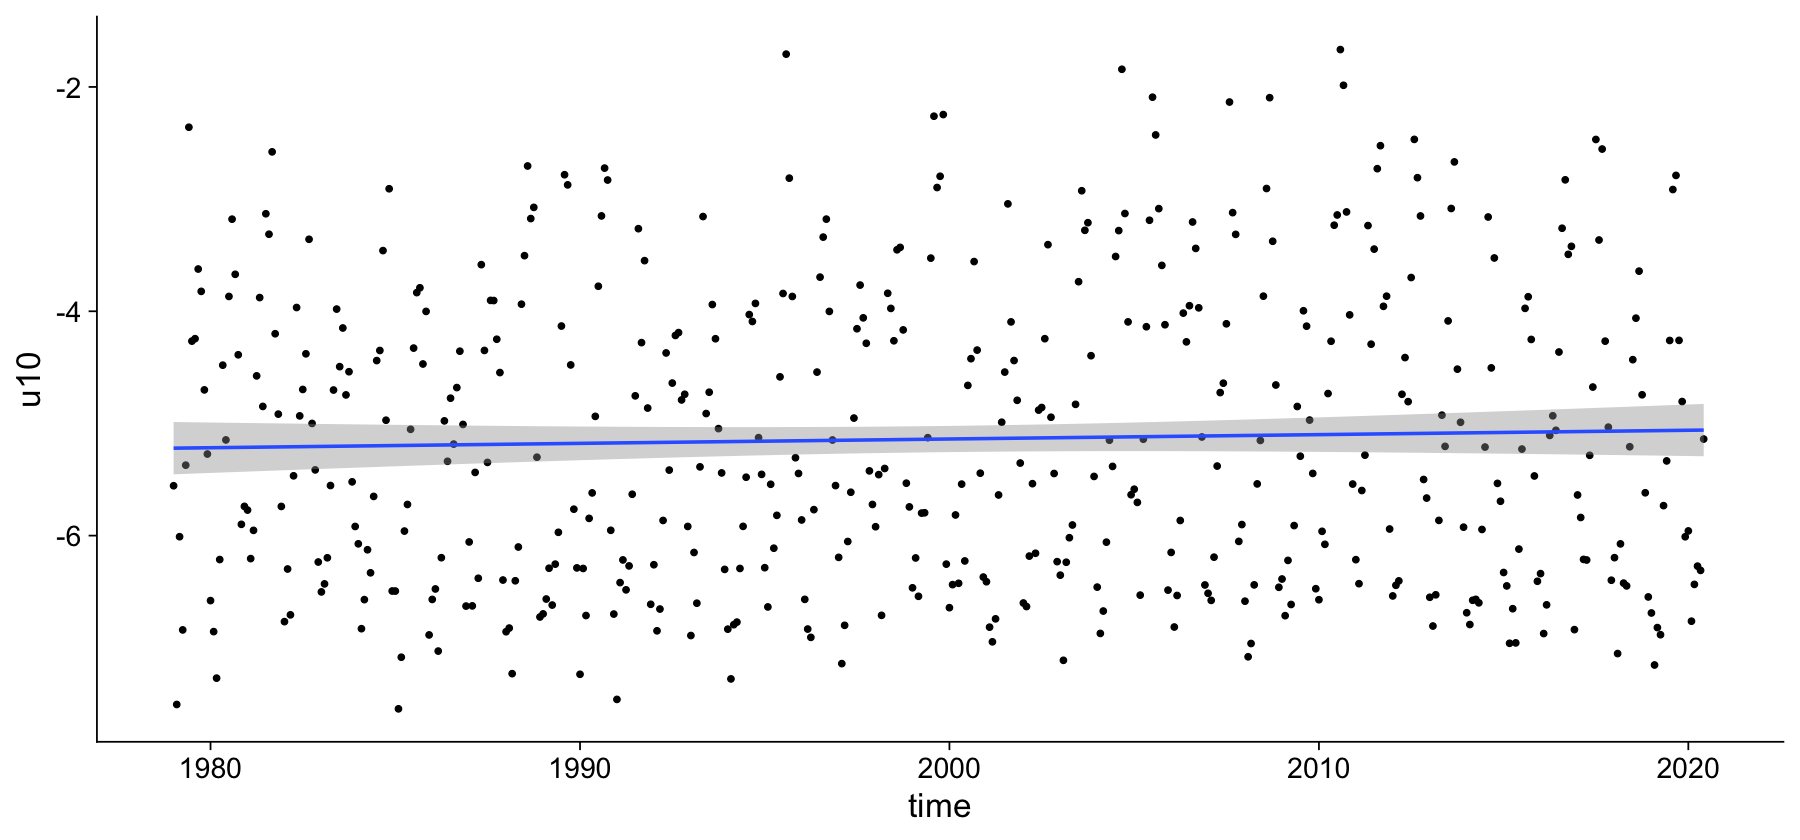

In [253]:
ggplot(data=wind_ds,aes(x=time, y=u10)) + geom_point() + 
geom_smooth(method='lm') + 
#geom_smooth()+
    theme_cowplot(font_size = 20)

Warning message:
“Removed 796 rows containing missing values (geom_point).”
Warning message:
“Removed 960 rows containing missing values (geom_point).”


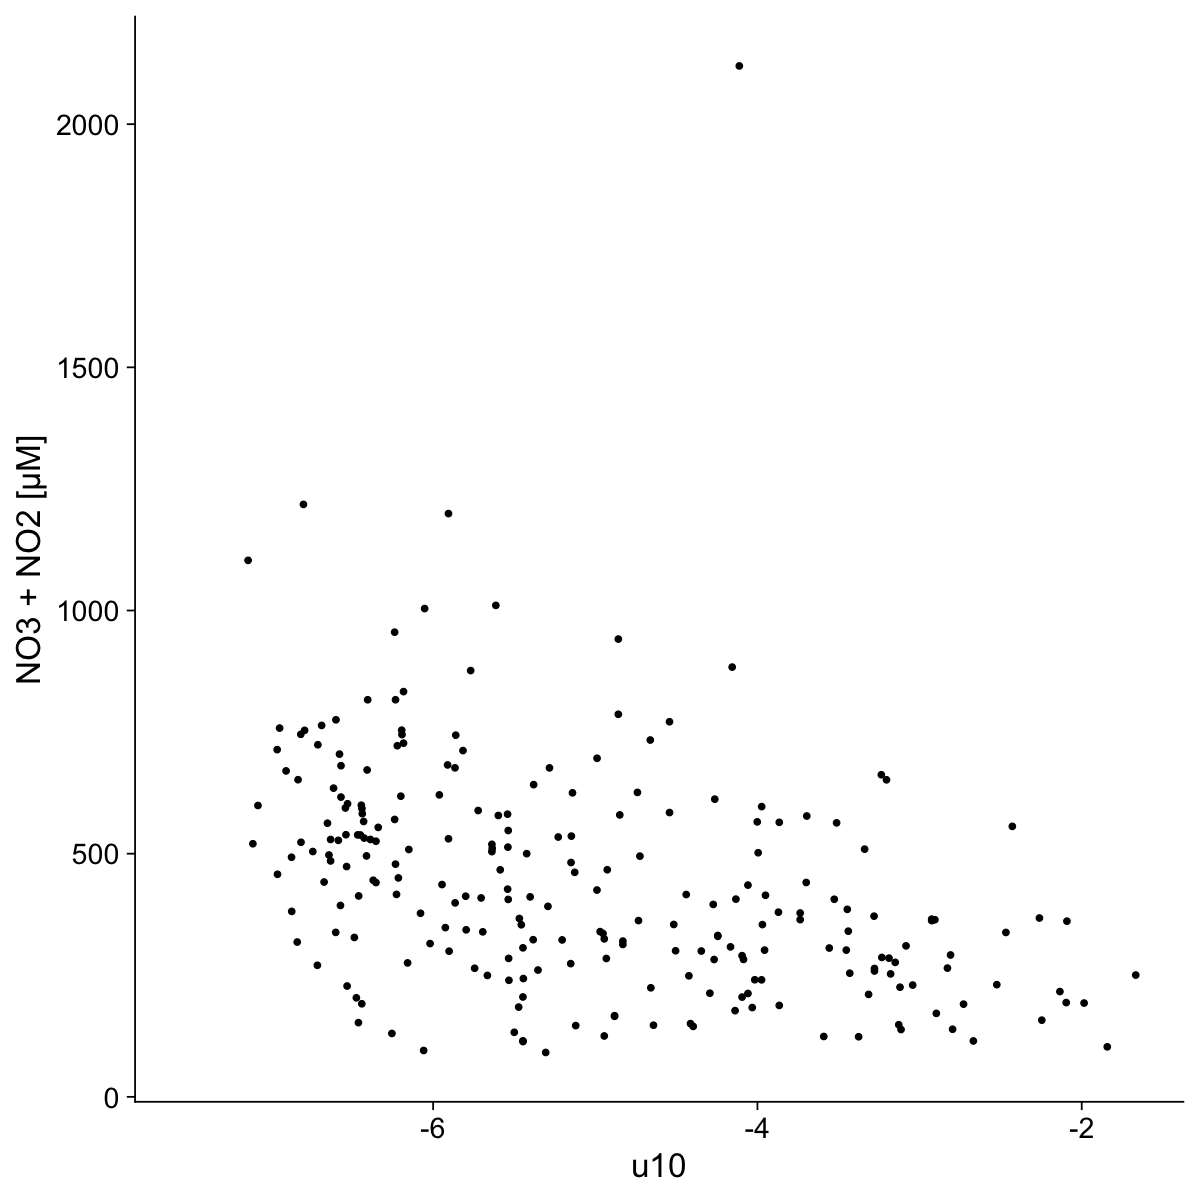

In [242]:
options(repr.plot.width=10, repr.plot.height=10)

niskin_wind_NO3_NO2_USF = interpolatedmerge('NO3_NO2_USF', 'u10')
niskin_wind_NO3_UDO = interpolatedmerge('NO3_UDO', 'u10')

ggplot(data=niskin_wind_NO3_NO2_USF, aes(y=value_intgrtd, x=u10)) + geom_point() + 
    geom_point(data=niskin_wind_NO3_UDO, aes(y=value_intgrtd, x=u10)) +
    theme_cowplot(font_size = 20) + ylab('NO3 + NO2 [µM]')

Warning message:
“Removed 771 rows containing missing values (geom_point).”
Warning message:
“Removed 956 rows containing missing values (geom_point).”


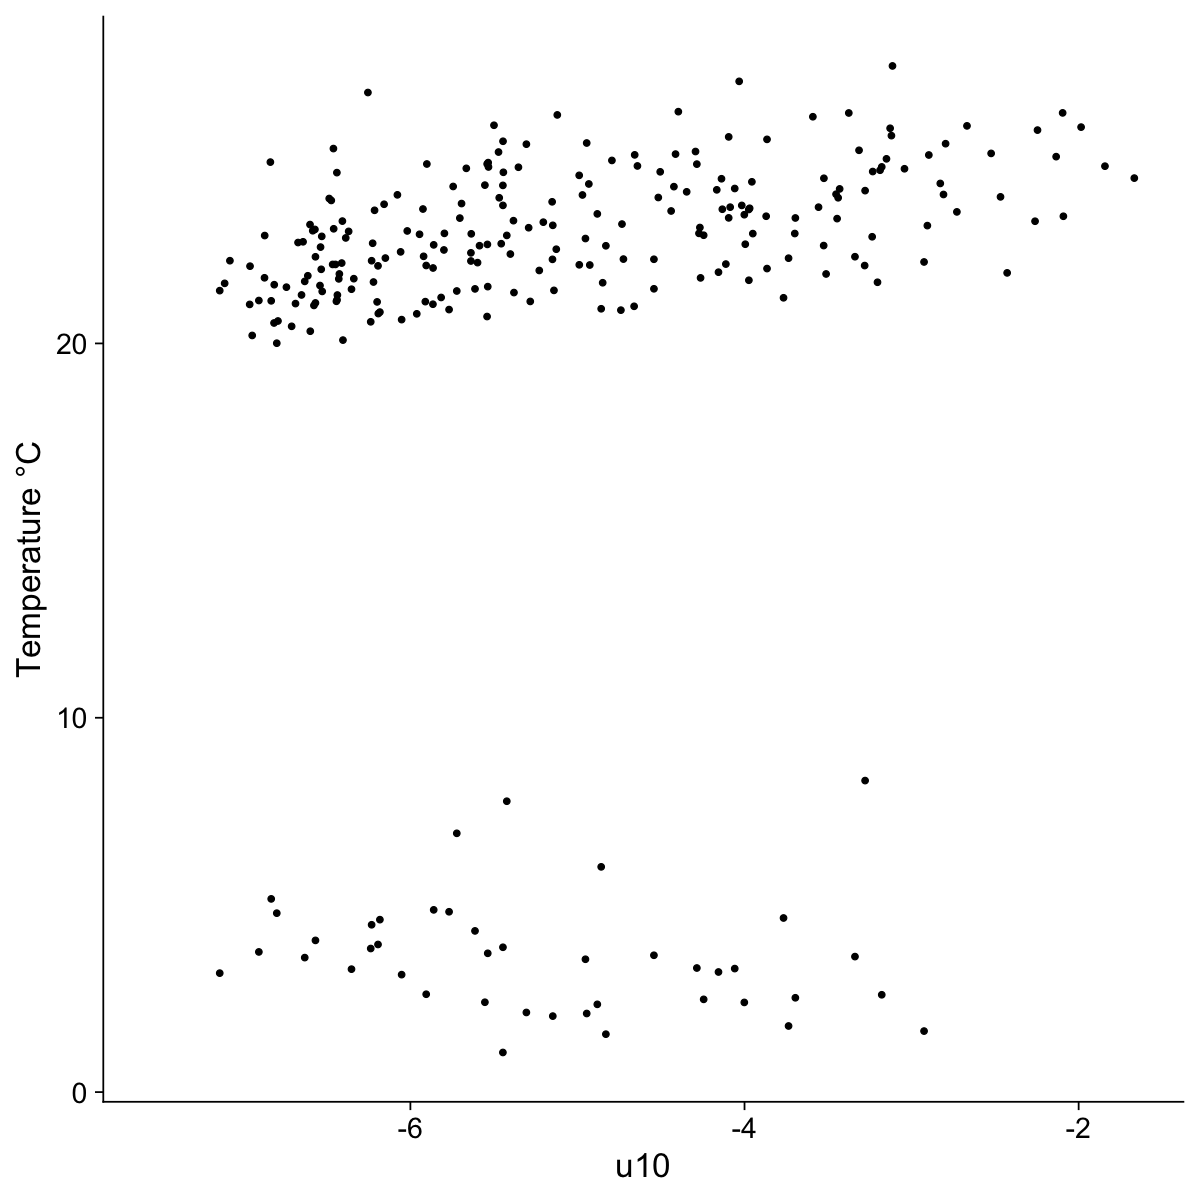

In [243]:
niskin_wind_Temperature = interpolatedmerge('Temperature', 'u10')

ggplot(data=niskin_wind_Temperature, aes(y=value_mean, x=u10)) + geom_point() + 
    geom_point(data=niskin_wind_SiO4_UDO, aes(y=value_mean, x=u10)) +
    theme_cowplot(font_size = 20) + ylab('Temperature °C')

Warning message:
“Removed 771 rows containing missing values (geom_point).”
Warning message:
“Removed 956 rows containing missing values (geom_point).”


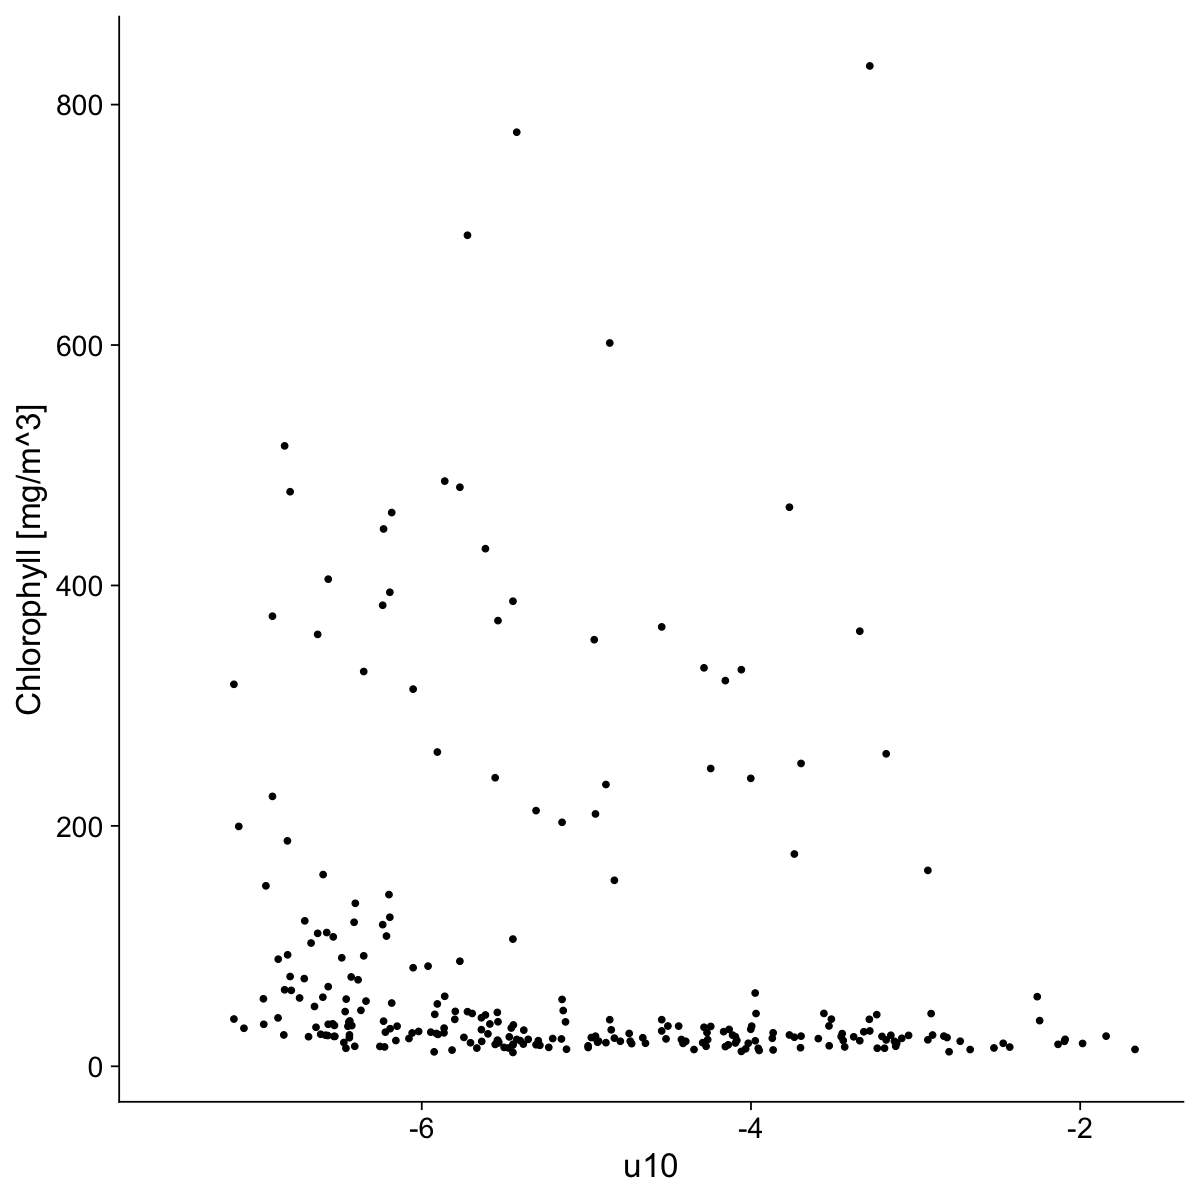

In [245]:
niskin_wind_Chlorophyll = interpolatedmerge('Chlorophyll', 'u10')

ggplot(data=niskin_wind_Chlorophyll, aes(y=value_intgrtd, x=u10)) + geom_point() + 
    geom_point(data=niskin_wind_SiO4_UDO, aes(y=value_intgrtd, x=u10)) +
    theme_cowplot(font_size = 20) + ylab('Chlorophyll [mg/m^3]')

Warning message:
“Removed 796 rows containing missing values (geom_point).”


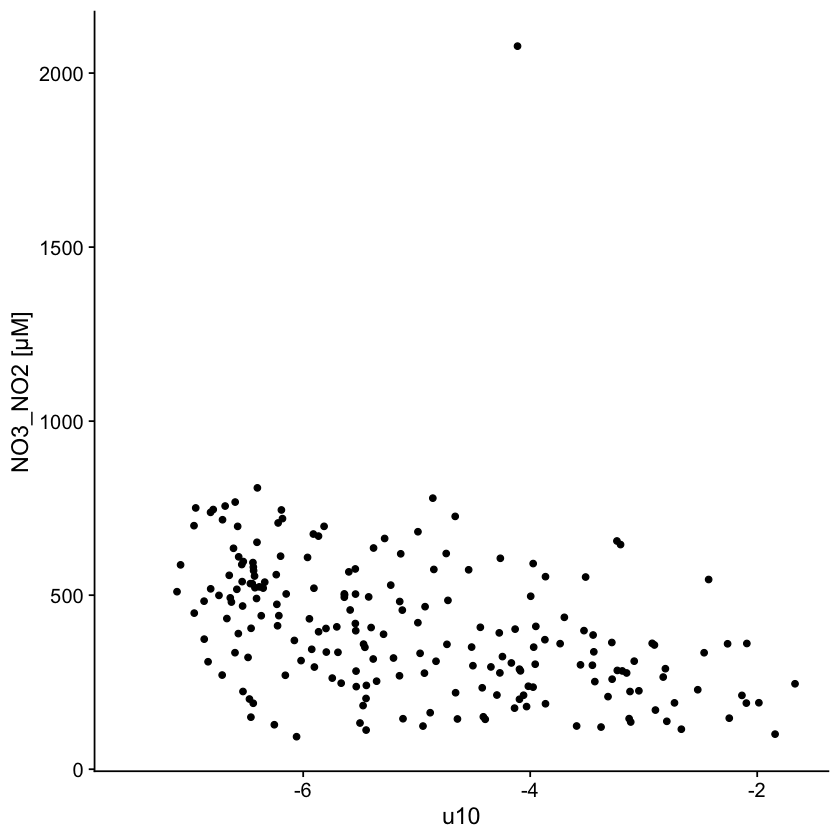

In [170]:
niskin_wind_NO3_NO2_USF = interpolatedmerge('NO3_NO2_USF', 'u10')

ggplot(data=niskin_wind_NO3_NO2_USF) + geom_point(aes(y=value_sum ,x=u10)) + 
theme_cowplot() + ylab('NO3_NO2 [µM]')

In [160]:
niskin_NO3_NO2_USF

time_month,u10,date,value_sum,value_mean,value_intgrtd,NAs,time
<chr>,<dbl>,<date>,<dbl>,<dbl>,<dbl>,<int>,<dttm>
01-1979,-5.555541,NA,NA,NA,NA,NA,1979-01-01
01-1979,NA,NA,NA,NA,NA,NA,1979-01-01
01-1980,-6.579281,NA,NA,NA,NA,NA,1980-01-01
01-1980,NA,NA,NA,NA,NA,NA,1980-01-01
01-1981,-5.772392,NA,NA,NA,NA,NA,1981-01-01
01-1981,NA,NA,NA,NA,NA,NA,1981-01-01
01-1982,-6.766924,NA,NA,NA,NA,NA,1982-01-01
01-1982,NA,NA,NA,NA,NA,NA,1982-01-01
01-1983,-6.501889,NA,NA,NA,NA,NA,1983-01-01


## merge nisking to wind!

In [12]:
# here
ds_wind_niskin <- merge(wind_ds_monthly, niskin_ds_monthly, all=TRUE)

In [5]:
ds <- read.csv("../VeryNEWESTCariacoData/phytoplankton.csv")

ds$Datetime_UTC = parse_date_time(ds$Datetime_UTC, orders = "%Y-%m-%d H:M:S")
ds$Datetime_local = parse_date_time(ds$Datetime_local, orders = "%Y-%m-%d H:M:S")

ds$date = ds$Datetime_UTC

## now read Functional Group annotated csv

In [6]:
annotated_fg <- read.csv("worms_dat_annotated_OLDFUNCGROUP.csv", sep=";", dec=',', stringsAsFactor=FALSE)
#annotated_fg = annotated_fg[complete.cases(annotated_fg),]

# trim dataframe to relevant columns
AphiaID2FG <- data.frame("AphiaID" = annotated_fg$AphiaID, 
                         "FuncGroup"=as.character(annotated_fg$functionalgroup_old), 
                         stringsAsFactors=FALSE)

## and merge with ds by AphiaID

In [7]:
ds_FG <- merge(ds, AphiaID2FG, all=TRUE)

In [8]:
ds_FG$FuncGroup[ds_FG$ScientificName_accepted == "nanoflagellates"]   <- "NANOFLAGELLATES"
ds_FG$FuncGroup[ds_FG$ScientificName_accepted == "palmelloid colony"] <- "PALMELLOIDCOLONY"

# Now let's plot some raw counts:

Warning message:
“Removed 1 rows containing missing values (geom_point).”

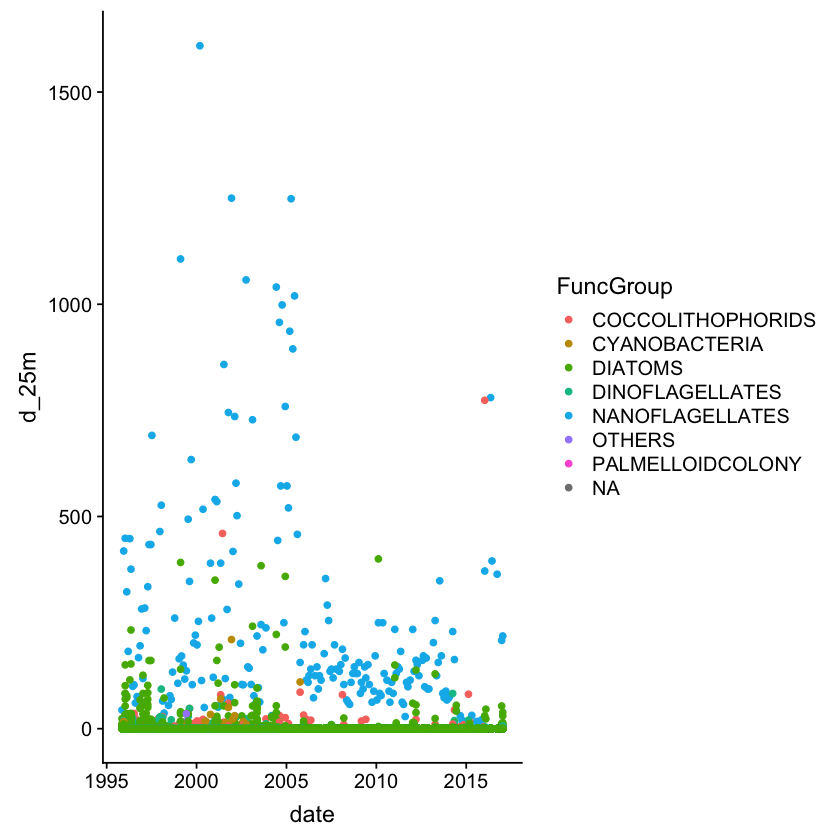

In [9]:
ggplot(data=ds_FG, aes(x=date, y=d_25m, color=FuncGroup)) + geom_point()

# save code: